In [164]:
import pathlib

path=str(pathlib.Path().resolve())+"/assets/"

In [165]:
#!pip install -q opencv-python

In [166]:
import os
import numpy as np
import cv2 as cv
import random

def get_data(path):
    images = []  # Lista para las imágenes
    labels = []  # Lista para las etiquetas
    dirs = os.listdir(path)
    
    for dir in dirs:
        for img in os.listdir(path+"/"+dir):
            images.append(cv.cvtColor(cv.resize(cv.imread(path +"/"+  dir + "/" + img), dsize=(128, 128),interpolation=cv.INTER_AREA),cv.COLOR_BGR2GRAY))
            if dir=="NORMAL":
                labels.append(0)
            else:
                labels.append(1)
    
    # Barajar las imágenes y las etiquetas de manera sincronizada
    combined = list(zip(images, labels))
    random.shuffle(combined)
    images, labels = zip(*combined)
    
    print(path + "/" + dirs[1])
    
    # Convertir las listas en arrays NumPy
    
    return np.array(images),np.array(labels) 


In [167]:
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor() as executor:
    f1 = executor.submit(get_data, path+"train")
    f2 = executor.submit(get_data, path+"test")
    f3 = executor.submit(get_data, path+"val")

    train = f1.result()
    test = f2.result()
    val = f3.result()


C:\Users\diego.guizanlopez\Documents\BigDataEIa\IA\Sistemas_Aprendizaje_Automatico\3-Trimestre\Redes_Neuronales\Clasificacion_Imagen\Ejercicio/assets/val/PNEUMONIA
C:\Users\diego.guizanlopez\Documents\BigDataEIa\IA\Sistemas_Aprendizaje_Automatico\3-Trimestre\Redes_Neuronales\Clasificacion_Imagen\Ejercicio/assets/test/PNEUMONIA
C:\Users\diego.guizanlopez\Documents\BigDataEIa\IA\Sistemas_Aprendizaje_Automatico\3-Trimestre\Redes_Neuronales\Clasificacion_Imagen\Ejercicio/assets/train/PNEUMONIA


In [168]:
X=np.concatenate((train[0],test[0],val[0]))
y=np.concatenate((train[1],test[1],val[1]))

In [169]:
from sklearn.model_selection import train_test_split

X_train_full, X_test , y_train_full, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val , y_train, y_val = train_test_split(X_train_full,y_train_full,test_size=0.2,random_state=42)

In [170]:
X_train

array([[[ 46,  67,  71, ...,  66,  66, 102],
        [ 50,  72,  76, ..., 100,  98, 123],
        [ 56,  76,  79, ...,  91,  83, 100],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[ 72,  79,  69, ..., 188, 194, 197],
        [ 80,  68,  59, ..., 190, 194, 198],
        [ 80,  76,  66, ..., 190, 194, 198],
        ...,
        [ 32,  31,  30, ...,  96, 163, 184],
        [ 32,  31,  31, ...,  84, 157, 186],
        [ 32,  31,  31, ...,  98, 146, 179]],

       [[ 16,  24,  29, ...,  15,  61, 146],
        [  7,  21,  26, ...,  15,  60, 146],
        [  1,  17,  23, ...,  15,  59, 145],
        ...,
        [  0,   0,   0, ...,   0,  12,  71],
        [  0,   0,   0, ...,   0,  13,  72],
        [  0,   0,   0, ...,   0,  11,  70]],

       ...,

       [[ 13,  13,  12, ..., 158, 168, 174],
        [ 12,  12,  11, ..., 155, 159, 171],
        [ 11,  12,  12, ..., 150, 160, 168

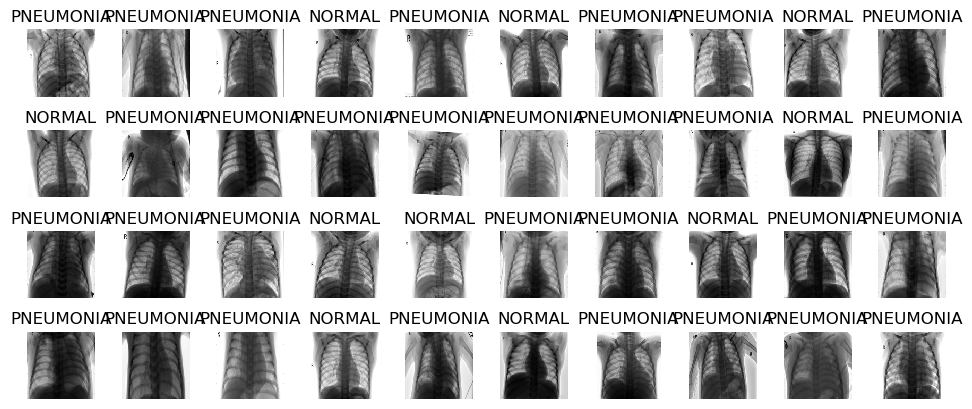

In [171]:
from matplotlib import pyplot as plt


class_names = ["NORMAL","PNEUMONIA"]

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [172]:
X_train.shape

(3747, 128, 128)

In [173]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical


In [174]:
X_train,y_train = X_train / 255.,y_train
X_test = X_test / 255.
X_val = X_val / 255.

In [175]:
#X_val,y_val=X_test[:int(len(X_test)/2)],y_test[:int(len(y_test)/2)]
#X_test,y_test=X_test[int(len(X_test)/2):],y_test[int(len(y_test)/2):]

In [176]:
#X_train=X_train.astype(np.uint8,copy=False)
#X_test=X_test.astype(np.uint8,copy=False)
#X_val=X_val.astype(np.uint8,copy=False)
#X_train

In [177]:
print(X_train.shape)
print(X_test.shape)

(3747, 128, 128)
(1172, 128, 128)


In [178]:
X_val

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.28235294,
         0.22745098, 0.20784314],
        [0.        , 0.        , 0.        , ..., 0.27058824,
         0.22352941, 0.19215686],
        [0.        , 0.        , 0.        , ..., 0.2627451 ,
         0.21568627, 0.18431373],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [179]:
X_train.shape
#(1280, 64, 64, 3)

(3747, 128, 128)

In [184]:
model = models.Sequential()

# Va hacer 32 Kernels que serán 3X3 es decir
# Recogera de cada 3 pixeles el central para la nueva imagen 
# Podríamos indicar los Strides (1,1) que son las casillas que avanza
# Le decimos que sea 28 x 28 y que tenga un canal
model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(X.shape[1],X.shape[2],1)))
#model.add(layers.Conv2D(32,(3,3),activation="relu"))

# Se va reduciendo la imagen por lo que podemos aumentar el número de filtros, donde la imagen se nos va a la mitad
model.add(layers.MaxPooling2D((2,2)))

# Lo normal es aumentar el número de filtros en la imagen
model.add(layers.Conv2D(64,(3,3),activation="relu"))
#model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))

# Aplana la capa actual
model.add(layers.Conv2D(128,(3,3),activation="relu"))
#model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())

model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))

model.summary()

c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\deep-learning\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

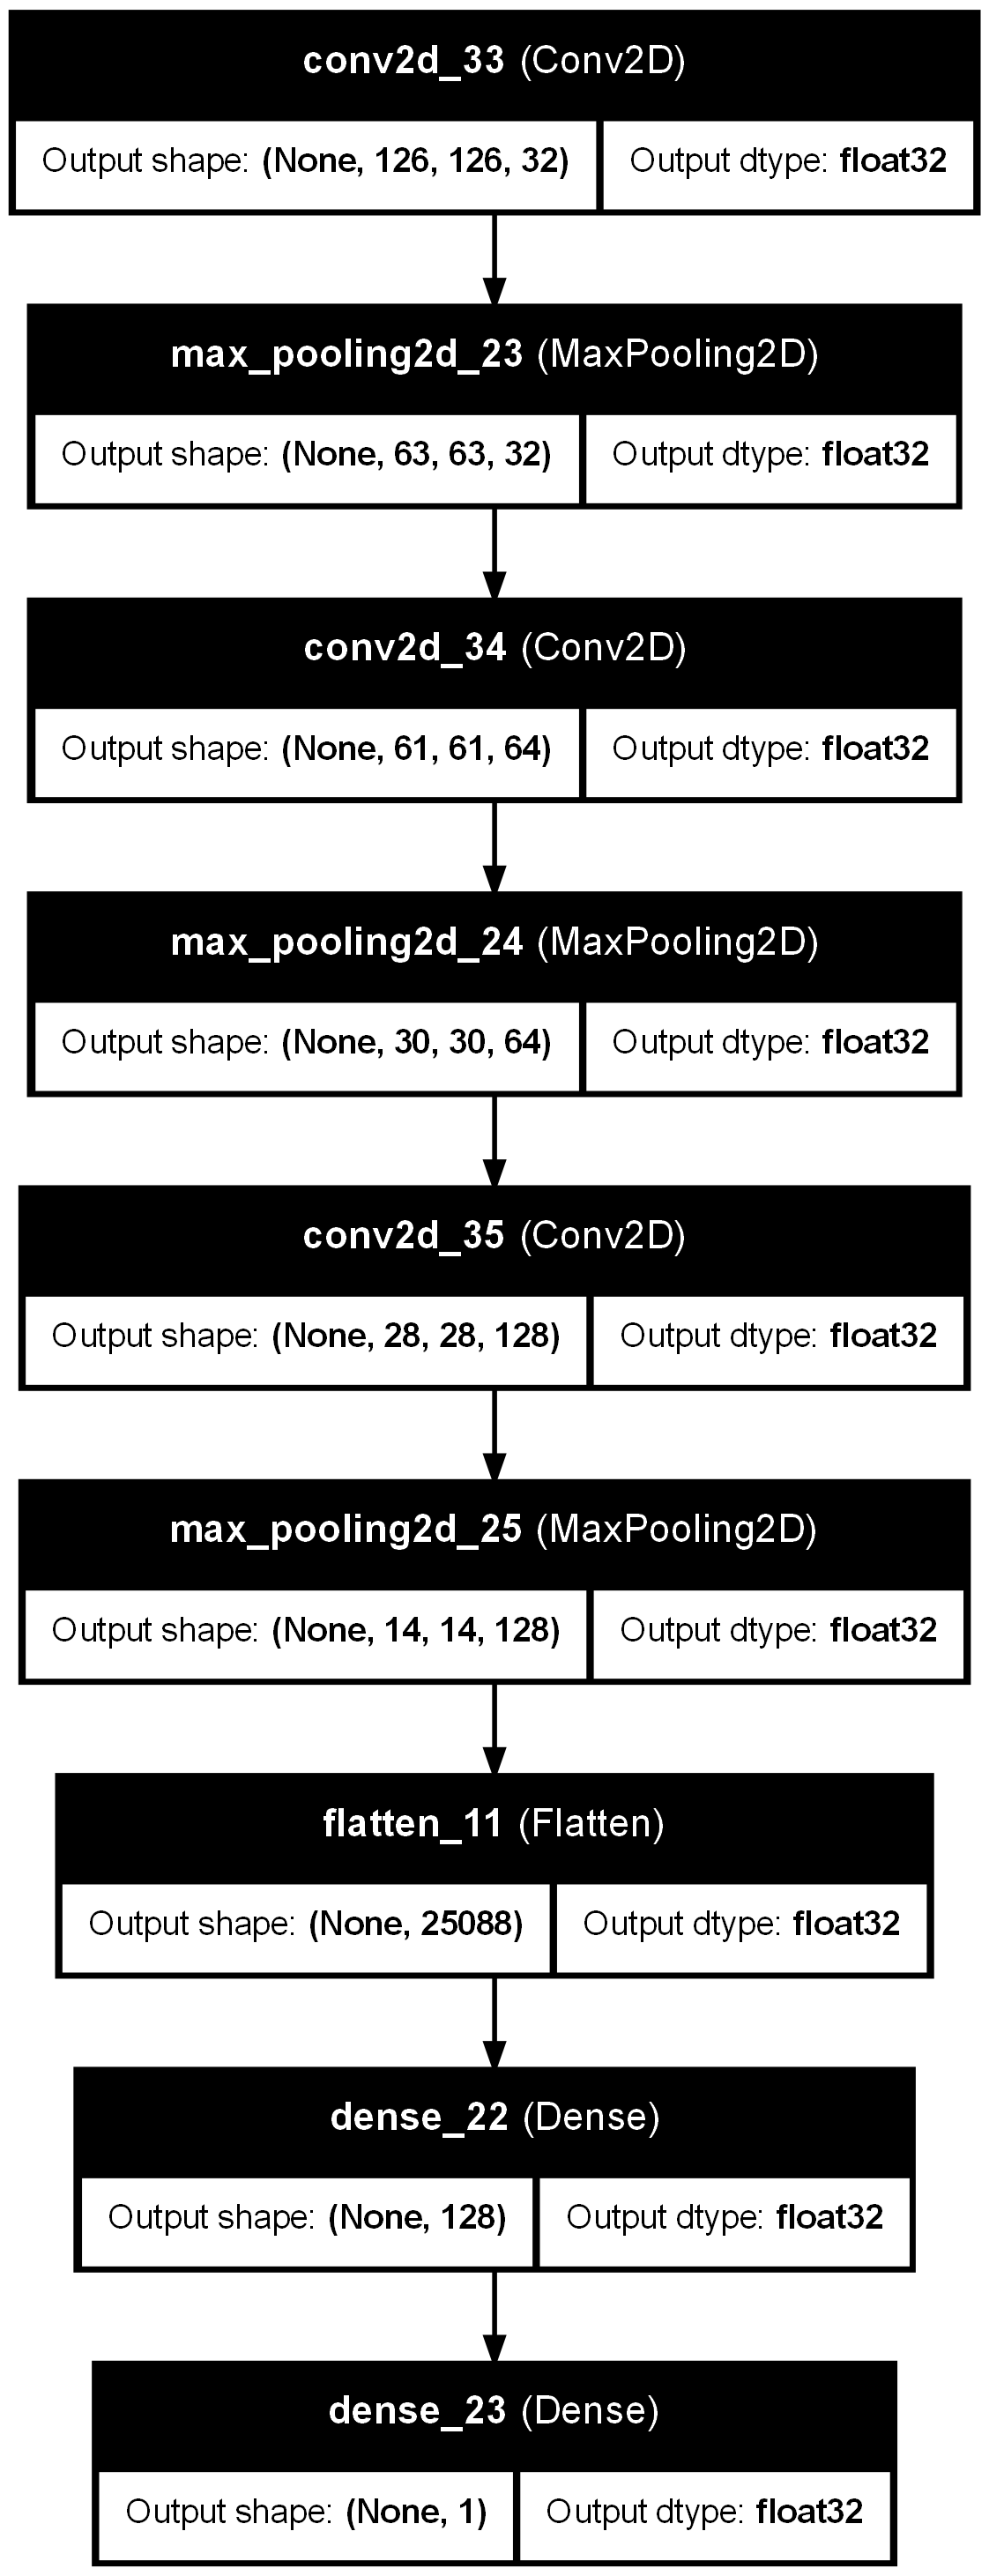

In [185]:
keras.utils.plot_model(model, "model.png", show_shapes=True,show_dtype=True,show_layer_names=True,)

In [186]:
model.compile(loss="binary_crossentropy",  optimizer=keras.optimizers.Adam(learning_rate=0.001),   metrics=["accuracy"])

In [187]:

import sys

#gpus = tf.config.experimental.list_physical_devices('GPU')
#print(gpus)
#tf.config.set_visible_devices([], 'CPU') # hide the CPU
#tf.config.set_visible_devices(gpus[0], 'GPU') # unhide potentially hidden GPU
#tf.config.get_visible_devices()


cpus = tf.config.experimental.list_physical_devices('CPU')
print(cpus)
tf.config.set_visible_devices([], 'GPU')  # hide the GPU
tf.config.set_visible_devices(cpus[0], 'CPU') # unhide potentially hidden CPU
tf.config.get_visible_devices()

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)




history = model.fit(X_train,y_train,epochs=sys.maxsize,validation_data=(X_val,y_val),callbacks=[early_stopping_cb])

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Epoch 1/9223372036854775807
118/118 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.8151 - loss: 0.4519 - val_accuracy: 0.9253 - val_loss: 0.2031
Epoch 2/9223372036854775807
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.9303 - loss: 0.1871 - val_accuracy: 0.9253 - val_loss: 0.2168
Epoch 3/9223372036854775807
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.9338 - loss: 0.1767 - val_accuracy: 0.9285 - val_loss: 0.1922
Epoch 4/9223372036854775807
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.9465 - loss: 0.1497 - val_accuracy: 0.9509 - val_loss: 0.1578
Epoch 5/9223372036854775807
118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9536 - loss: 0.1181 - val_accuracy: 0.9530 - val_loss: 0.1368
Epoch 6/9223372036854775807
118/118 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 0.9593 - loss: 0.1028 - val_accuracy: 0.9541 - val_loss: 0.1235
Epoch 7/9223372036854775807
118/118 ━━━━━━━━━

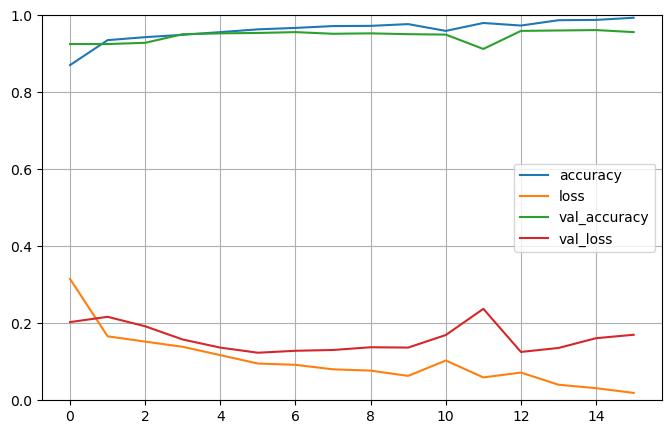

In [188]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [189]:
model.evaluate(X_test,y_test)
#accuracy: 0.9582 - loss: 0.1282

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9504 - loss: 0.1148


[0.11978498101234436, 0.9513651728630066]

In [190]:
y_test_pred = model.predict(X_test)
y_test_pred_labels = y_test_pred.round(0)
y_test_true_labels = y_test

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


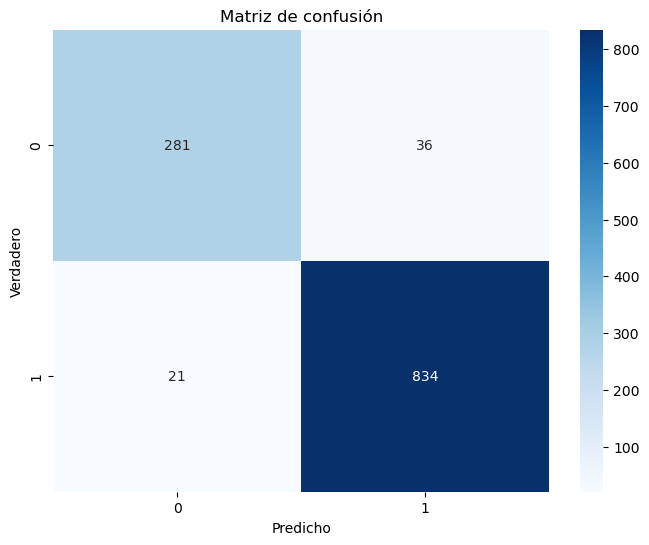

In [191]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_true_labels, y_test_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.title('Matriz de confusión')
plt.show()